# Análisis de reducción de dimensiones y agrupamiento

### Cargar datos

In [1]:
# Importar librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import umap
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
# Load the data
df = pd.read_excel('../data/processed/coprolitos_processed.xlsx')

# Inspeccionar primeros elementos
df.head()

,Ejemplar,Numero_de_inclusiones,Agujeros,Lineas_de_corrosion,Señal_quimica,Diametro_mm,Arreglo_de_inclusiones,Forma_de_fracturas_en_terminaciones
0,bump headed lace,4,2,1,1,1,2,5
1,bump headed lace,4,2,2,1,1,2,3
2,circular,1,2,1,1,1,4,5
3,circular,3,2,2,1,2,4,5
4,cilíndrico,1,2,1,1,3,1,5


## Reducción de dimensiones: UMAP

Aplicar UMAP

In [3]:
# Seleccionar las columnas relevantes para la reducción de dimensiones
data = df.select_dtypes(include=[int, float])  # Seleccionamos solo las columnas numéricas

# Aplicar UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(data)

# Crear un nuevo dataframe con las dimensiones reducidas
umap_df = pd.DataFrame(embedding, columns=['UMAP_1', 'UMAP_2'])

# Inspeccionar el nuevo dataframe
umap_df.head()

c:\Users\jcbar\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


,UMAP_1,UMAP_2
0,7.366081,-4.322462
1,8.837674,-3.260088
2,6.175919,-2.866338
3,6.391541,-3.304647
4,7.449560,-2.697191


Añadir columna Ejemplar

In [4]:
# Añadimos la columna Ejemplar al nuevo dataframe
umap_df['Ejemplar'] = df['Ejemplar'].str.title()

# Inspeccionamos nuevamente 
umap_df.head()

,UMAP_1,UMAP_2,Ejemplar
0,7.366081,-4.322462,Bump Headed Lace
1,8.837674,-3.260088,Bump Headed Lace
2,6.175919,-2.866338,Circular
3,6.391541,-3.304647,Circular
4,7.449560,-2.697191,Cilíndrico


Añadir columna con nombres abreviados

In [5]:
# Crear el nuevo diccionario de abreviaciones
abbreviation_dict = {
    'Bump Headed Lace': 'BHL',
    'Circular': 'Cir',
    'Cilíndrico': 'Cil',
    'Cono': 'Cono',
    'Elipsoidal': 'Elip',
    'Elongado': 'Elon',
    'Forma De Pino': 'FP',
    'Irregular': 'Irr',
    'Forma De Rosario': 'FR',
    'Espiral': 'Esp',
    'Forma De Encaje Recto': 'FER',
    'Encaje Delgado': 'ED'
}

# Aplicar las abreviaciones al dataframe
umap_df['Abreviatura'] = umap_df['Ejemplar'].map(abbreviation_dict)

# Inspeccionamos nuevamente 
umap_df.head()

,UMAP_1,UMAP_2,Ejemplar,Abreviatura
0,7.366081,-4.322462,Bump Headed Lace,BHL
1,8.837674,-3.260088,Bump Headed Lace,BHL
2,6.175919,-2.866338,Circular,Cir
3,6.391541,-3.304647,Circular,Cir
4,7.449560,-2.697191,Cilíndrico,Cil


Gráfica de dispersión

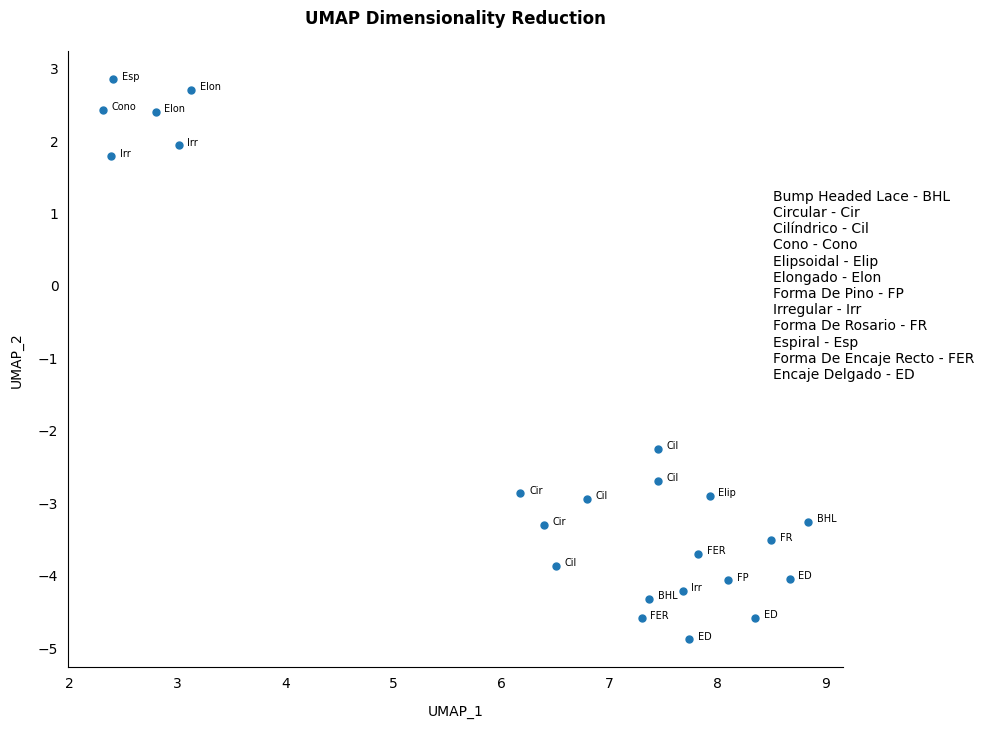

In [6]:
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 8))

# Crear el gráfico de dispersión con etiquetas abreviadas y aumentar el tamaño de los puntos
ax.scatter(umap_df['UMAP_1'], umap_df['UMAP_2'], s=25)  # Ajustar el tamaño de los puntos

# Añadir etiquetas a cada punto
for i in range(len(umap_df)):
    ax.text(umap_df['UMAP_1'][i] + 0.08, umap_df['UMAP_2'][i], umap_df['Abreviatura'][i], fontsize=7)

ax.set_title('UMAP Dimensionality Reduction', pad=20, fontweight='bold')
ax.set_xlabel('UMAP_1', labelpad=10)
ax.set_ylabel('UMAP_2', labelpad=10)

# Desactivar las marcas en el eje x de la subgráfica inferior
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
# Desactivar las marcas en el eje y de la subgráfica inferior
ax.tick_params(axis='y', which='both', left=False)
# Mantener solo el borde izquierdo y inferior de la subgráfica inferior
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Crear la caja de texto con el catálogo de nombres y abreviaciones
catalog_text = "\n".join([f"{key} - {value}" for key, value in abbreviation_dict.items()])
fig.text(0.91, 0.62, catalog_text, transform=ax.transAxes, fontsize=10, verticalalignment='center', bbox=dict(boxstyle="round,pad=0.3", edgecolor="white", facecolor="white"))

plt.show()

## Agrupamiento: DBSCAN

Criterio del codo para determinar epsilon

In [7]:
# Calcular las distancias a los vecinos más cercanos utilizando la métrica de Bray-Curtis
neighbors = NearestNeighbors(n_neighbors=5, metric='braycurtis')
neighbors_fit = neighbors.fit(embedding)
distances, indices = neighbors_fit.kneighbors(embedding)

# Ordenar las distancias para trazar la gráfica del codo
distances = np.sort(distances, axis=0)
distances = distances[:, 1]  # Tomar la segunda distancia más pequeña (ya que la primera es siempre 0)

# Identificar el punto del codo utilizando la segunda derivada
second_derivative = np.diff(np.diff(distances))
elbow_index = np.argmax(second_derivative) + 1

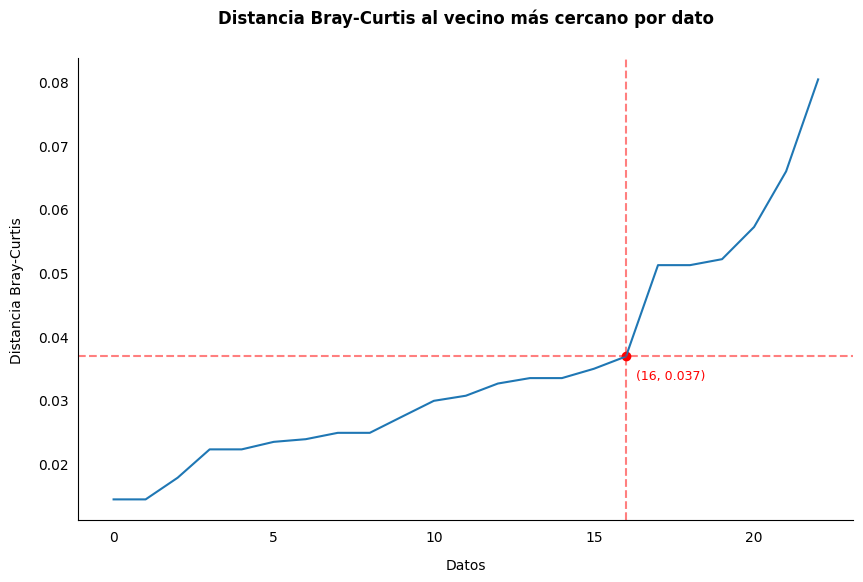

In [8]:
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Crear la gráfica del codo
ax.plot(distances)
ax.set_title('Distancia Bray-Curtis al vecino más cercano por dato', fontweight='bold', pad=25)
ax.set_xlabel('Datos', labelpad=10)
ax.set_ylabel('Distancia Bray-Curtis', labelpad=10)

# Agregar líneas y círculo en el punto del codo
elbow_x = elbow_index
elbow_y = distances[elbow_index]
ax.axvline(x=elbow_x, color='red', alpha=0.5, linestyle='--')
ax.axhline(y=elbow_y, color='red', alpha=0.5, linestyle='--')
ax.scatter(elbow_x, elbow_y, color='red')  # Círculo rojo
ax.text(elbow_x + 0.3, elbow_y - 0.004, f'({elbow_x}, {elbow_y:.3f})', color='red', fontsize=9, verticalalignment='bottom')

# Desactivar las marcas en el eje x de la subgráfica inferior
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
# Desactivar las marcas en el eje y de la subgráfica inferior
ax.tick_params(axis='y', which='both', left=False)
# Mantener solo el borde izquierdo y inferior de la subgráfica inferior
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

Aplicar DBSCAN

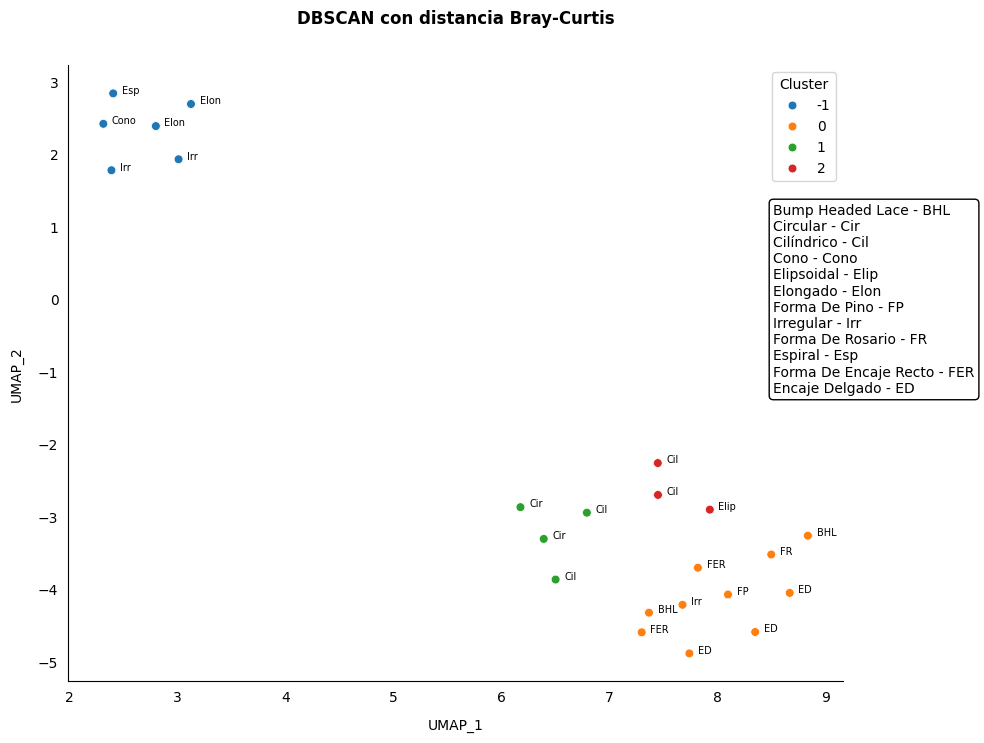

In [9]:
# Aplicar DBSCAN con métrica de Bray-Curtis
dbscan = DBSCAN(eps=0.037, min_samples=3, metric='braycurtis')
umap_df['Cluster'] = dbscan.fit_predict(embedding)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 8))

# Crear el gráfico de dispersión con etiquetas abreviadas y código de color para los clusters
sns.scatterplot(x='UMAP_1', y='UMAP_2', hue='Cluster', palette='tab10', data=umap_df, s=40, ax=ax, legend='full')

# Añadir etiquetas a cada punto
for i in range(len(umap_df)):
    ax.text(umap_df['UMAP_1'][i] + 0.08, umap_df['UMAP_2'][i], umap_df['Abreviatura'][i], fontsize=7)

ax.set_title('DBSCAN con distancia Bray-Curtis', pad=30, fontweight='bold')
ax.set_xlabel('UMAP_1', labelpad=10)
ax.set_ylabel('UMAP_2', labelpad=10)

# Desactivar las marcas en el eje x de la subgráfica inferior
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
# Desactivar las marcas en el eje y de la subgráfica inferior
ax.tick_params(axis='y', which='both', left=False)
# Mantener solo el borde izquierdo y inferior de la subgráfica inferior
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Crear la caja de texto con el catálogo de nombres y abreviaciones
catalog_text = "\n".join([f"{key} - {value}" for key, value in abbreviation_dict.items()])
fig.text(0.91, 0.62, catalog_text, transform=ax.transAxes, fontsize=10, verticalalignment='center', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

plt.show()

## Agrupamiento: Clustering Alomerativo Jerárquico

Equivalente al criterio del codo: **dendograma y distancia de corte**

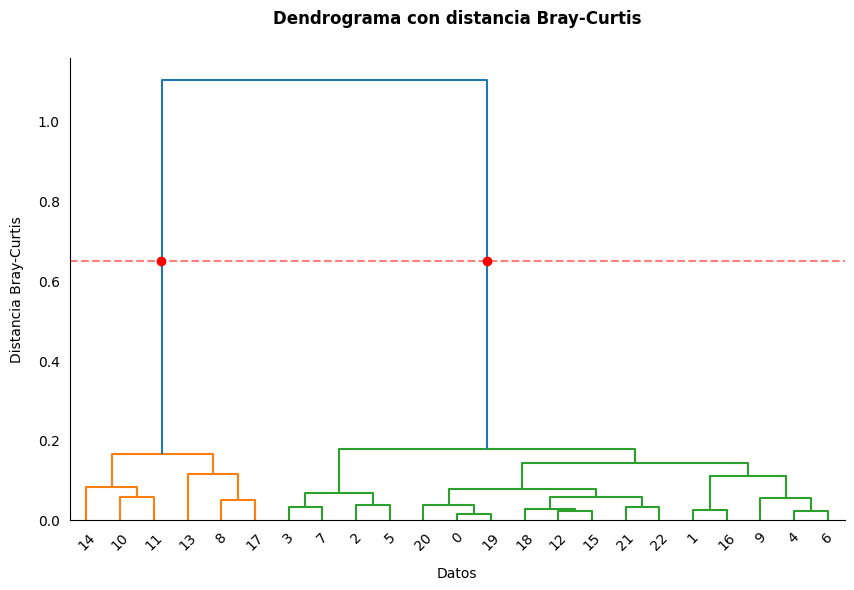

In [10]:
# Calcular el linkage matrix para el clustering jerárquico utilizando la métrica de Bray-Curtis
linkage_matrix = linkage(embedding, method='complete', metric='braycurtis')

# Crear la figura y los ejes para la gráfica del dendrograma
fig, ax = plt.subplots(figsize=(10, 6))

# Crear el dendrograma
dendro = dendrogram(linkage_matrix, ax=ax)
ax.set_title('Dendrograma con distancia Bray-Curtis', fontweight='bold', pad=25)
ax.set_xlabel('Datos', labelpad=10)
ax.set_ylabel('Distancia Bray-Curtis', labelpad=10)

# Añadir la línea horizontal para indicar el punto de corte
cutoff_distance = 0.65  # Ajusta esta distancia según tu interpretación del dendrograma
ax.axhline(y=cutoff_distance, color='red', linestyle='--', alpha=0.5)

ax.plot(27, cutoff_distance, 'ro')
ax.plot(124, cutoff_distance, 'ro')     

# Desactivar las marcas en el eje x de la subgráfica inferior
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
# Desactivar las marcas en el eje y de la subgráfica inferior
ax.tick_params(axis='y', which='both', left=False)
# Mantener solo el borde izquierdo y inferior de la subgráfica inferior
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

Aplicamos el Clustering Jerárquico Aglomerativo

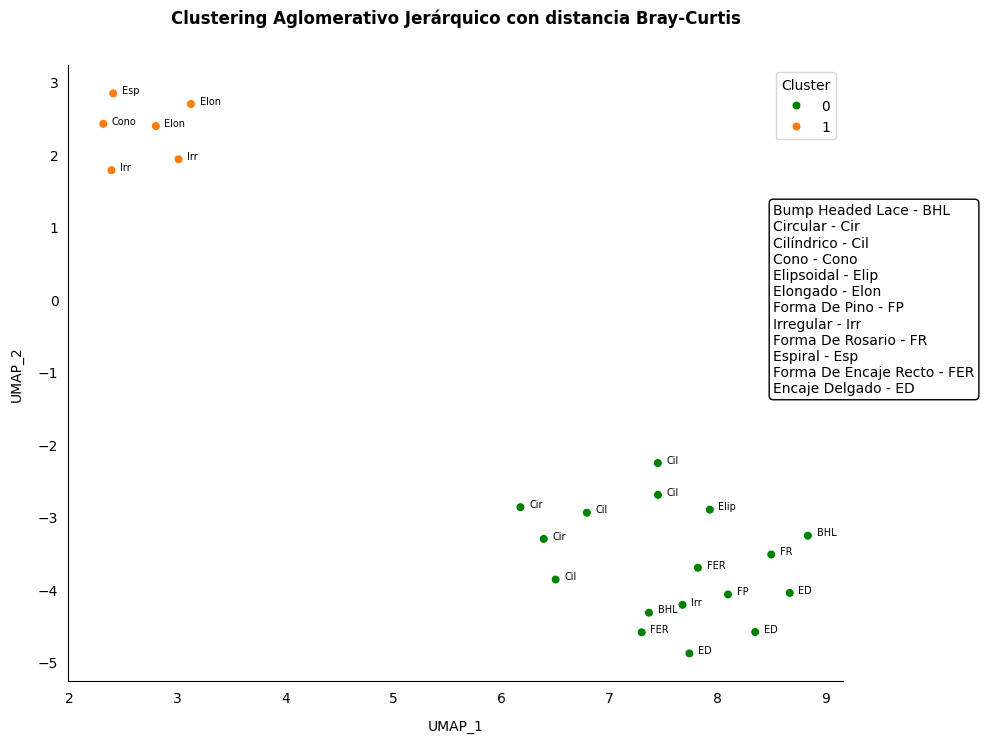

In [11]:
# Selección del número de clusters
optimal_clusters = 2  # Basado en la observación del dendrograma

# Aplicar AgglomerativeClustering con el número óptimo de clusters
agg_clustering = AgglomerativeClustering(n_clusters=optimal_clusters, metric='braycurtis', linkage='complete')
umap_df['Cluster'] = agg_clustering.fit_predict(embedding)

# Crear la figura y los ejes para la gráfica de dispersión
fig, ax = plt.subplots(figsize=(10, 8))

# Crear el gráfico de dispersión con etiquetas abreviadas y código de color para los clusters
sns.scatterplot(x='UMAP_1', y='UMAP_2', hue='Cluster', palette=['green', '#fb7c0c'], data=umap_df, s=40, ax=ax, legend='full')

# Añadir etiquetas a cada punto
for i in range(len(umap_df)):
    ax.text(umap_df['UMAP_1'][i] + 0.08, umap_df['UMAP_2'][i], umap_df['Abreviatura'][i], fontsize=7)

ax.set_title('Clustering Aglomerativo Jerárquico con distancia Bray-Curtis', pad=30, fontweight='bold')
ax.set_xlabel('UMAP_1', labelpad=10)
ax.set_ylabel('UMAP_2', labelpad=10)

# Desactivar las marcas en el eje x de la subgráfica inferior
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
# Desactivar las marcas en el eje y de la subgráfica inferior
ax.tick_params(axis='y', which='both', left=False)
# Mantener solo el borde izquierdo y inferior de la subgráfica inferior
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Crear la caja de texto con el catálogo de nombres y abreviaciones
catalog_text = "\n".join([f"{key} - {value}" for key, value in abbreviation_dict.items()])
fig.text(0.91, 0.62, catalog_text, transform=ax.transAxes, fontsize=10, verticalalignment='center', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

plt.show()